In [46]:
from PIL import Image

from math import pi, sqrt, exp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, fsolve

def normal(x, n, sigma, mu):
    return n * np.exp(-(((x - mu) / sigma) ** 2) / 2) / (sigma * sqrt(2 * pi))

In [66]:
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rc('font', size=12)

In [2]:
sigmas = []

for i in range(12):
	img = np.asarray(Image.open(f"lab/images/pos-{i}.tif"))

	a = img[:, :, 0]
	ind = np.unravel_index(np.argmax(a, axis=None), a.shape)

	fig, ax = plt.subplots()
	ax.plot(img[:, ind[1], 0])
	y = img[:, ind[1], 0]
	x = np.arange(y.shape[0])

	(n, sigma, mu) = curve_fit(normal, x, y, p0=(200, 400, 10))[0]

	sigmas.append(sigma)

	ax.plot(x, y)
	ax.plot(x, normal(x, n, sigma, mu))

	plt.savefig(f"lab/plots/plot-{i}.pdf")
	plt.close()

array([7.85755959, 0.49530219])

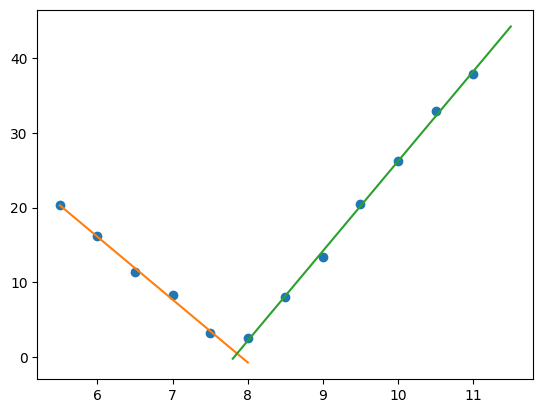

In [21]:
from numpy.polynomial.polynomial import Polynomial


def eval_poly(x, coef):
    result = 0
    for i, c in enumerate(coef):
        result += c * (x**i)

    return result

start = 11.5 - 0.5 * 12
end = 11.5

fig, ax = plt.subplots()
x = np.arange(start, end, step=0.5)
y = sigmas[::-1]

ax.plot(x, y, "o")

a = []
b = []

poly = Polynomial.fit(x[:5], y[:5], 1)
coef = poly.convert().coef

a.append([coef[1], -1])
b.append(-coef[0])

_x = np.linspace(start, 8, num=50)
ax.plot(_x, eval_poly(_x, coef))

poly = Polynomial.fit(x[5:], y[5:], 1)
coef = poly.convert().coef

a.append([coef[1], -1])
b.append(-coef[0])

_x = np.linspace(7.8, end, num=50)
ax.plot(_x, eval_poly(_x, coef))

np.linalg.solve(a, b)

Sigma: 45.75000789867486
Mu: 392.0660907863463
FWHM: 107.74126860137929
Beam diameter (FWHM): 0.5009688413743821 mm
Beam diameter (1/e^2): 0.8509024906571245 mm


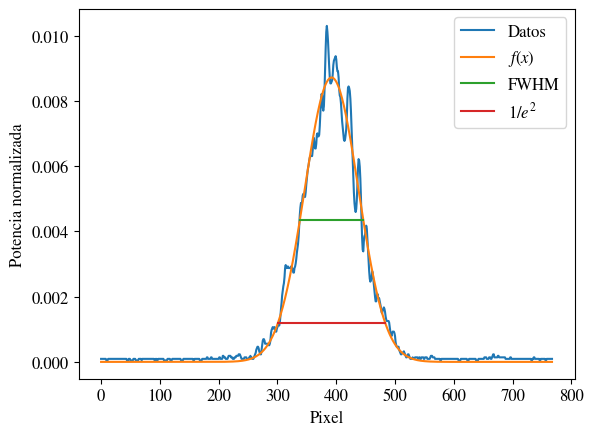

In [76]:
img = np.asarray(Image.open(f"lab/images/LaserCintura.tif"))

a = img[:, :, 0]
ind = np.unravel_index(np.argmax(a, axis=None), a.shape)

fig, ax = plt.subplots()
ax.set_xlabel("Pixel")
ax.set_ylabel("Potencia normalizada")

y = img[:, ind[1], 0]
x = np.arange(y.shape[0])

(n, sigma, mu) = curve_fit(normal, x, y, p0=(200, 400, 10))[0]

ax.plot(x, y / n, label="Datos")
ax.plot(x, normal(x, 1, sigma, mu), label=r"$f(x)$")

maxi = normal(mu, 1, sigma, mu)

x1 = fsolve(lambda x: normal(x, 1, sigma, mu) - (maxi / 2), 300)[0]
x2 = fsolve(lambda x: normal(x, 1, sigma, mu) - (maxi / 2), 450)[0]
x = np.linspace(x1, x2)
ax.plot(x, np.repeat(maxi / 2, x.shape[0]), label="FWHM")

x1 = fsolve(lambda x: normal(x, 1, sigma, mu) - maxi * (1 / exp(2)), 300)[0]
x2 = fsolve(lambda x: normal(x, 1, sigma, mu) - maxi * (1 / exp(2)), 500)[0]

x = np.linspace(x1, x2)
ax.plot(x, np.repeat(maxi / exp(2), x.shape[0]), label="$1/e^2$")
ax.legend()

print(f"Sigma: {sigma}")
print(f"Mu: {mu}")
print(f"FWHM: {2.355 * sigma}")
print(f"Beam diameter (FWHM): {(3.571 / y.shape[0]) * 2.355 * sigma} mm")
print(f"Beam diameter (1/e^2): {(3.571 / y.shape[0]) * (x2 - x1)} mm")

plt.savefig("lab/plots/plot-LaserCintura.pdf")

Sigma: 97.79557969732285
Mu: 375.89435794625075
FWHM: 230.3085901871953
Beam diameter (FWHM): 1.070874968175097 mm
Beam diameter (1/e^2): 1.8188959119746864 mm


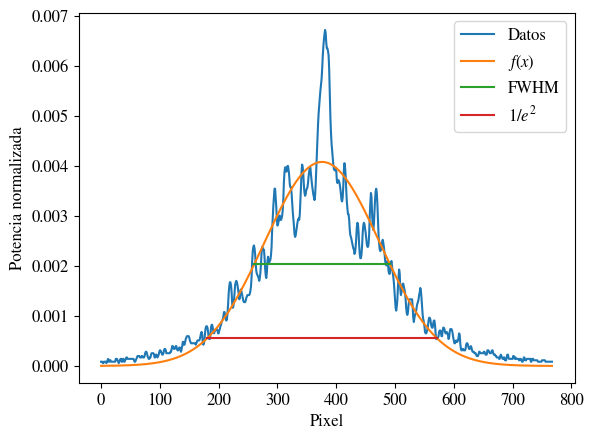

In [75]:
img = np.asarray(Image.open(f"lab/images/FibraCintura.tif"))

a = img[:, :, 0]
ind = np.unravel_index(np.argmax(a, axis=None), a.shape)

fig, ax = plt.subplots()
ax.set_xlabel("Pixel")
ax.set_ylabel("Potencia normalizada")

y = img[:, ind[1], 0]
x = np.arange(y.shape[0])

(n, sigma, mu) = curve_fit(normal, x, y, p0=(200, 400, 10))[0]

ax.plot(x, y / n, label="Datos")
ax.plot(x, normal(x, 1, sigma, mu), label=r"$f(x)$")

maxi = normal(mu, 1, sigma, mu)

x1 = fsolve(lambda x: normal(x, 1, sigma, mu) - (maxi / 2), 300)[0]
x2 = fsolve(lambda x: normal(x, 1, sigma, mu) - (maxi / 2), 450)[0]
x = np.linspace(x1, x2)
ax.plot(x, np.repeat(maxi / 2, x.shape[0]), label="FWHM")

x1 = fsolve(lambda x: normal(x, 1, sigma, mu) - maxi * (1 / exp(2)), 300)[0]
x2 = fsolve(lambda x: normal(x, 1, sigma, mu) - maxi * (1 / exp(2)), 500)[0]

x = np.linspace(x1, x2)
ax.plot(x, np.repeat(maxi / exp(2), x.shape[0]), label="$1/e^2$")
ax.legend()

print(f"Sigma: {sigma}")
print(f"Mu: {mu}")
print(f"FWHM: {2.355 * sigma}")
print(f"Beam diameter (FWHM): {(3.571 / y.shape[0]) * 2.355 * sigma} mm")
print(f"Beam diameter (1/e^2): {(3.571 / y.shape[0]) * (x2 - x1)} mm")

plt.savefig("lab/plots/plot-FibraCintura.pdf")